In [43]:
"""
Exploring nldas trends.


Using these websites for inspiration ------

https://foundations.projectpythia.org/core/xarray/computation-masking.html#


"""

import os
import pandas as pd
import numpy as np
import xarray as xr


# Set up Pathing -----------------------------------------
wd = "/glade/u/home/milesmoore/SRM_CLM/notebooks"

if os.getcwd() != wd:
    os.chdir(wd)
print(f'Current working directory {os.getcwd()}')

data_dir = "../data/"
nldas_dir = "../data/nldas_processed/"

f_tpqwl = os.path.join(nldas_dir, "nldas_srm_precip.nc")

Current working directory /glade/u/home/milesmoore/SRM_CLM/notebooks


In [44]:
ds = xr.open_dataset(f_tpqwl)
ds.isel(time=0)

<xarray.Dataset>
Dimensions:    (latitude: 96, longitude: 80, scalar: 1)
Coordinates:
  * longitude  (longitude) float32 -111.9 -111.8 -111.7 ... -102.3 -102.2 -102.1
  * latitude   (latitude) float32 33.06 33.19 33.31 33.44 ... 44.69 44.81 44.94
    time       object 1980-01-31 00:00:00
Dimensions without coordinates: scalar
Data variables:
    LONGXY     (latitude, longitude) float32 ...
    LATIXY     (latitude, longitude) float32 ...
    EDGEE      (scalar) float32 ...
    EDGEW      (scalar) float32 ...
    EDGES      (scalar) float32 ...
    EDGEN      (scalar) float32 ...
    PRECTmms   (latitude, longitude) float32 ...
Attributes:
    case_title:  NLDAS 1-Hourly Atmospheric Forcing: Precipitation

In [45]:
import pandas as pd
import numpy as np
import xarray as xr
import os

# Load the CSV of centroids
centroids_df = pd.read_csv(os.path.join(data_dir, "tundra_cells.csv"))

latitudes = centroids_df['latitude'].values
longitudes = centroids_df['longitude'].values

# Create a 2D mask for the dataset based on latitude and longitude
mask_2d = np.zeros((ds.sizes['latitude'], ds.sizes['longitude']), dtype=bool)

# Update the 2D mask based on centroids
for lat, lon in zip(latitudes, longitudes):
    mask_2d |= (ds['latitude'] == lat) & (ds['longitude'] == lon)


# Apply the mask to the dataset
masked_ds = ds.where(mask_2d, drop=True)

masked_ds.to_netcdf("../data/nldas_processed/nldas_srmat_precip.nc")

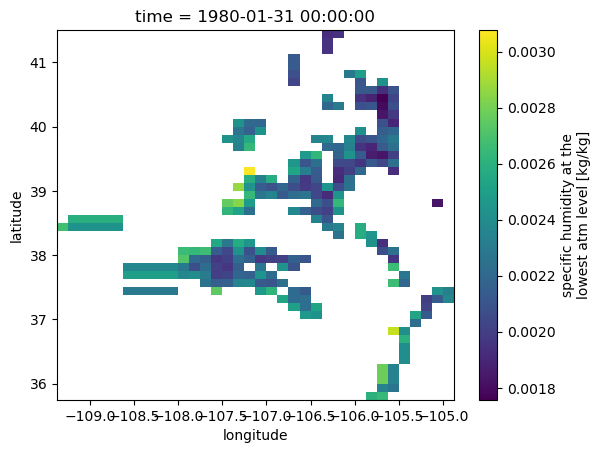

In [40]:
masked_ds.QBOT.isel(time=0).plot()